# Google Lenet test for lungs dataset.
Fine tunning on 5 ephocs

## Load Dataset into a trainloader and transform to 256x256

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
plt.ion()

## Trainer and validator

In [2]:

def train(net, epochs, trainloader, optimizer, criterion=nn.CrossEntropyLoss(), title="", writer=None):
    print(
        f"training {title} network for {epochs} epochs, {'tensorboard enabled' if writer else 'no tensorboard enabled'}")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    for epoch in range(epochs):
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 200))
                if writer:
                    writer.add_scalar(
                        'training loss, ' + title, running_loss/200, epoch)
                    writer.add_scalar('accuracy, '+title,
                                        running_correct/200, epoch)

                running_loss = 0.0
                running_correct = 0.0

    print('Finished Training')

def validate(net, testloader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("testing network:")
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print("total accuracy of net: %.2f%%" % (correct/total*100))

In [5]:
data_transforms = transforms.Compose([
        transforms.Resize([512,512]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


data_dir = './data/'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                        for x in ['train', 'test', 'val']}

class_names = image_datasets['train'].classes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'val']}


## Load GoogleLeNet and set output layer to 2

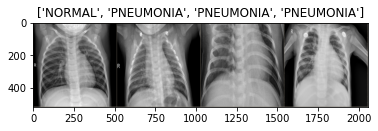

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
trainloader = dataloaders['train']
testloader = dataloaders['test']
valloader = dataloaders['val']

gnet = models.googlenet(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


gnet.fc = nn.Linear(1024, 2)
gnet.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [9]:
opt = optim.SGD(gnet.parameters(),lr=1e-4, momentum=0.9)

train(gnet, 5, trainloader, opt, title="Googlelenet")



training Googlelenet network for 5 epochs, no tensorboard enabled
[1,   200] loss: 0.551
[1,   400] loss: 0.429
[1,   600] loss: 0.386
[1,   800] loss: 0.355
[1,  1000] loss: 0.309
[1,  1200] loss: 0.256
[2,   200] loss: 0.270
[2,   400] loss: 0.222
[2,   600] loss: 0.232
[2,   800] loss: 0.209
[2,  1000] loss: 0.211
[2,  1200] loss: 0.204
[3,   200] loss: 0.166
[3,   400] loss: 0.200
[3,   600] loss: 0.199
[3,   800] loss: 0.186
[3,  1000] loss: 0.212
[3,  1200] loss: 0.149
[4,   200] loss: 0.132
[4,   400] loss: 0.209
[4,   600] loss: 0.164
[4,   800] loss: 0.123
[4,  1000] loss: 0.155
[4,  1200] loss: 0.160
[5,   200] loss: 0.116
[5,   400] loss: 0.140
[5,   600] loss: 0.141
[5,   800] loss: 0.119
[5,  1000] loss: 0.142
[5,  1200] loss: 0.081
Finished Training


In [13]:
validate(gnet, valloader)


testing network:
total accuracy of net: 62.50%


PermissionError: [Errno 13] Permission denied: './models'

In [15]:
torch.save(gnet.state_dict(), './models/gnet.pth')

In [16]:
validate(gnet, testloader)

testing network:
total accuracy of net: 82.21%


In [17]:
opt = optim.SGD(gnet.parameters(),lr=1e-4, momentum=0.9)

train(gnet, 20, trainloader, opt, title="Googlelenet")


training Googlelenet network for 20 epochs, no tensorboard enabled
[1,   200] loss: 0.111
[1,   400] loss: 0.090
[1,   600] loss: 0.108
[1,   800] loss: 0.128
[1,  1000] loss: 0.158
[1,  1200] loss: 0.140
[2,   200] loss: 0.128
[2,   400] loss: 0.102
[2,   600] loss: 0.097
[2,   800] loss: 0.069
[2,  1000] loss: 0.083
[2,  1200] loss: 0.080
[3,   200] loss: 0.079
[3,   400] loss: 0.063
[3,   600] loss: 0.091
[3,   800] loss: 0.092
[3,  1000] loss: 0.130
[3,  1200] loss: 0.071
[4,   200] loss: 0.098
[4,   400] loss: 0.057
[4,   600] loss: 0.081
[4,   800] loss: 0.063
[4,  1000] loss: 0.111
[4,  1200] loss: 0.063
[5,   200] loss: 0.080
[5,   400] loss: 0.090
[5,   600] loss: 0.104
[5,   800] loss: 0.092
[5,  1000] loss: 0.089
[5,  1200] loss: 0.059
[6,   200] loss: 0.074
[6,   400] loss: 0.049
[6,   600] loss: 0.048
[6,   800] loss: 0.040
[6,  1000] loss: 0.041
[6,  1200] loss: 0.053
[7,   200] loss: 0.036
[7,   400] loss: 0.048
[7,   600] loss: 0.058
[7,   800] loss: 0.067
[7,  1000] lo

In [19]:
torch.save(gnet.state_dict(), './models/gnetHeavy.pth')
print("validate")
validate(gnet, valloader)
print("test data")
validate(gnet, testloader)

validate
testing network:
total accuracy of net: 81.25%
test data
testing network:
total accuracy of net: 81.89%
